<a href="https://colab.research.google.com/github/yoooobin/ESAA/blob/main/ESAA_OB_week12_1_markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **5.2** 합성곱 신경망 맛보기

- fashion_mnist 데이터셋

In [13]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms   # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

- 파이토치는 기본적으로 GPU 사용을 권장
- GPU 장착, GPU 사용 설정시 파이토치에서 자동으로 인식

In [14]:
# CPU 혹은 GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


GPU 사용
- 일반적으로 하나의 GPU를 사용할 때는 아래의 코드를 사용

```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)
```
- 사용하는 PC에서 다수의 GPU를 사용한다면 nn.DataParallel 이용


```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
if torch.cuda.device_count() > 1:
   model = nn.DataParallel(net)
model.to(device)
```
- nn.DataParallel 사용할 경우 배치 크기가 알아서 각 GPU로 분배되는 방식으로 작동
- GPU 수만큼 배치 크기도 늘려야됨



In [15]:
# fashion_mnist 데이터셋 내려받기

train_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download=True, train=False,
                                                 transform=transforms.Compose([transforms.ToTensor()]))
                                                 # 앞에서 훈련 데이터셋을 내려받았다면 여기에서는 테스트 데이터셋을 내려받음

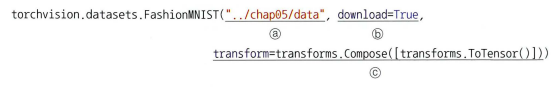
- (a) 첫 번째 파라미터: FashionMNIST 내려받을 위치 지정
- (b) download: download를 True로 변경해 주면 첫 번째 파라미터의 위치에 해당 데이터셋이 있는지 확인한 후 내려받음
- (c) transform: 이미지를 텐서(0~1)로변경

In [16]:
# fashion_mnist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=100)   # 1
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)

1. torch.utils.data.DataLoader()를 사용하여 원하는 크기의 배치 단위로 데이터를 불러오거나, 순서가 무작위로 섞이도록(shuffle). 데이터로더에서 사용하는 파라미터는 아래와 같음
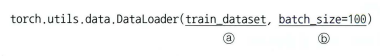

- (a) 첫 번째 파라미터: 데이터를 불러올 데이터셋을 지정
- (b) batch_size: 데이터를 배치로 묶어줌. batch_size=100으로 지정했기 때문에 100개 단위로 데이터를 묶어 불러옴

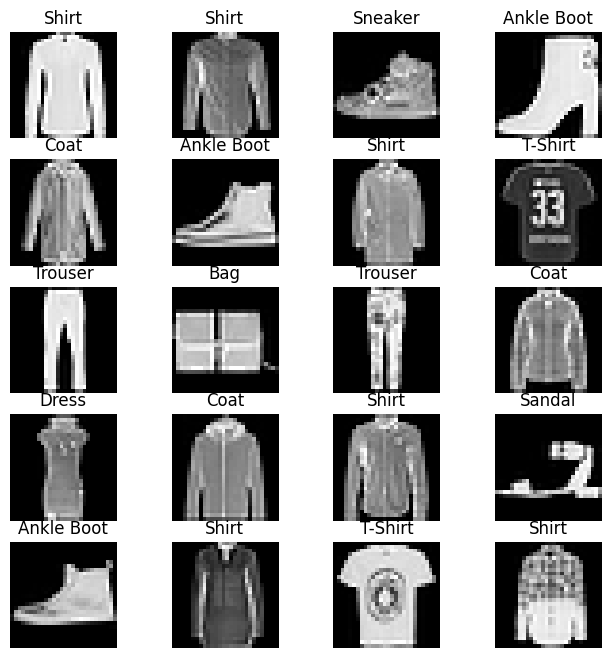

In [17]:
# 분류에 사용될 클래스 정의
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
              5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}   # 열 개의 클래스

fig = plt.figure(figsize=(8,8))   # 출력할 이미지의 가로세로 길이로, 단위는 inch
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));   # 1
    img = train_dataset[img_xy][0][0,:,:]             # 2
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()   # 20개의 이미지 데이터를 시각적으로 표현

1. np.random: 무작위로 데이터 생성할 때 사용. np.random.randint(): 이산형 분포를 갖는 데이터에서 무작위 표본을 추출할 때 사용.
  
  => random.randint(len(train_dataset)): 0~(train_dataset의 길이) 값을 갖는 분포에서 랜덤한 숫자 한 개를 생성하라는 의미


```
#  random.rand & random.randn 예시

import numpy as np
np.random.randint(10)     # 0~10의 임의의 숫자 출력

np.random.randint(1, 10)  # 1~9의 임의의 숫자 출력

np.random.rand(8)         # 0~1 사이의 정규표준분포 난수를 행렬로 (1x8) 출력

np.random.rand(4, 2)      # 0~1 사이의 정규표준분포 난수를 행렬로 (4x2) 출력

np.random.rand(8)         # 평균이 0이고, 표준편차가 1인 가우시안 정규분포 난수를 행렬로 (1x8) 출력

np.random.randn(4, 2)     # 평균이 0이고, 표준편차가 1인 가우시안 정규분포 난수를 행렬로 (4x2) 출력
```
2. train_dataset을 이용한 3차원 배열을 생성

```
# 배열 예시

import numpy as np

examp = np.arange(0, 100, 3)  # 1~99의 숫자에서 3씩 건너뛴 행렬을 생성
examp.resize(6, 4)

examp[3]                      # 3행에 해당하는 모든 값들을 출력(행과 열은 0부터 시작)

examp[3, 3]                   # 3행의 3번째 열에 대한 값을 출력

examp[3][3]                   # 3행의 3번째 열에 대한 값을 출력하기 때문에 바로 앞의 결과와 동일
```

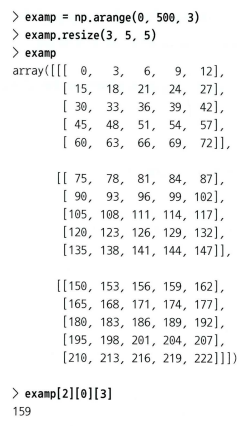
- train_dataset에서 [img_xy][0][0.:.:]에 해당하는 요소 값을 가져오겠다는 의미

In [18]:
# 심충 신경망 모델 생성
class FashionDNN(nn.Module):
    def __init__(self):   # 1
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)   # 2
        self.drop = nn.Dropout(0.25)   # 3
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):   # 4
        out = input_data.view(-1, 784)   # 5
        out = F.relu(self.fc1(out))   # 6
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

1. 클래스 형태의 모델은 항상 torch.nn.Module을 상속받음.
  - __ init __(): 객체가 갖는 속성 값을 초기화하는 역할, 객체가 생성될 때 자동으로 호출
  - super(FashionDNN, self).__ init __(): nn.Module 클래스를 상속받겠다는 의미
2. nn: 딥러닝 모델(네트워크) 구성에 필요한 모듈이 모여 있는 패키지. Linear은 단순 선형 회귀 모델 만들 때 사용


```
nn.Linear(in_features=784 #a, out_features=256 #b)
#a: in_features: 입력의 크기(input size)
#b: out_features: 출력의 크기(output_size)
```

3. torch.nn.Dropout(p): p만큼의 비율로 텐서의 값이 0이 됨, 0이 되지 않는 값들은 기존 값에 (1/(1-p))만큼 곱해져 커짐
4. forward() 함수: 모델이 학습 데이터를 입력받아 순전파(forward propagation) 학습을 진행시키며 반드시 forward라는 이름의 함수여야 함. 객체를 데이터와 함께 호출하면 자동으로 실행.
5. 파이토치에서 사용하는 뷰(view): 넘파이의 reshape와 같은 역할로 텐서의 크기(shape)를 변경해 주는 역할
  - input_data.view(-1, 784): input_data를 (?, 784)의 크기로 변경하라는 의미
6. 활성화 함수 지정하는 두 가지 방법
  - F.relu(): forward() 함수에서 정의
  - nn.ReLU(): __ init __() 함수에서 정의
  - 사용하는 위치의 차이 => nn.functional.xx(), nn.xx() 사용 방법에 차이


```
# nn을 사용하는 예시 코드

import torch
import torch.nn as nn

inputs = torch.randn(64, 3, 244, 244)
conv = nn.Conv2d(in_channels=3, out_channels=64,
                 kernel_size=3, padding=1) # 채널 3개 입력 -> 64개 출력을 위해 3x3크기의 커널 사용
outputs = conv(inputs)
layer = nn.Conv2d(1,1,3)
```


```
# nn.functional을 사용하는 예시 코드

import torch.nn.functional as F

inputs = torch.randn(64, 3, 244, 244)
weight = torch.randn(64, 3, 3, 3)
bias = torch.randn(64)
outputs = F.conv2d(inputs, weight, bias, padding=1)
```

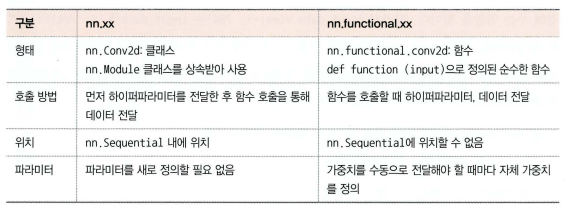


In [19]:
# 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();   # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);   # 1
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


1. 옵티마이저를 위한 경사 하강법은 Adam을 사용함. 학습률을 의미하는 lr은 0.001을 사용

In [20]:
# 심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = []   # 1
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:   # 2
        images, labels = images.to(device), labels.to(device)   # 3

        train = Variable(images.view(100, 1, 28, 28))   # 4
        labels = Variable(labels)

        outputs = model(train)   # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):   # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                test = Variable(images.view(100, 1, 28, 28))

                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()

                total += len(labels)

            accuracy = correct * 100 / total   # 5
            loss_list.append(loss.data)        # 1'
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data,
                                                                  accuracy))

Iteration: 500, Loss: 0.5777179002761841, Accuracy: 83.31999969482422%
Iteration: 1000, Loss: 0.4651643633842468, Accuracy: 84.33999633789062%
Iteration: 1500, Loss: 0.34496748447418213, Accuracy: 84.7699966430664%
Iteration: 2000, Loss: 0.42093533277511597, Accuracy: 85.47000122070312%
Iteration: 2500, Loss: 0.27016472816467285, Accuracy: 86.6500015258789%
Iteration: 3000, Loss: 0.28819847106933594, Accuracy: 85.94999694824219%


1. 일반적으로 배열이나 행렬과 같은 리스트(list)를 사용하는 방법
  - (1) 비어 있는 배열이나 행렬을 만듦
  - (1') append 메서드를 이용하여 데이터를 하나씩 추가
2. for 구문을 사용하여 레코드(행, 가로줄)를 하나씩 가져옴.
  - for x, y in train: in 앞에 변수를 두 개 지정 => 레코드에서 요소 두 개를 꺼내 오겠다는 의미
  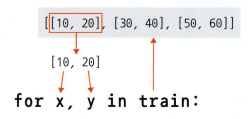
3. 모델이 데이터를 처리하기 위해 모델과 데이터가 동일한 장치(CPU/GPU)에 있어야 함. CPU에서 처리된 데이터를 GPU 모델에 적용하거나 그 반대의 경우 런타임 오류가 발생
4. Autograd: 자동 미분을 수행하는 파이토치의 핵심 패키지 => 자동 미분에 대한 값을 저장하기 위해 테이프(tape) 사용.
  - 순전파(forward) 단계: 테이프는 수행하는 모든 연산을 저장
  - 역전파(backward) 단계: 저장된 값들을 꺼내서 사용
  - Variable 사용해서 역전파를 위한 미분 값을 자동으로 계산 => torch.autograd 패키지 Variable
5. 분류 문제에 대한 정확도는 전체 예측에 대한 정확한 예측의 비율로 표현


```
# 백분율
classification accuracy = correct predictions / total predictions * 100

# 오분류율/오류율
error rate = (1-(correct predictions / total predictions)) * 100
```



<분류 문제에서 클래스가 세 개 이상일 때>
- 정확도 80% 이상: 80%라는 값이 모든 클래스가 동등하게 고려된 것인지, 특정 클래스의 분류가 높았던 것인지에 대해 알 수 없음에 유의
- 정확도 90% 이상: 모든 데이터를 특정 클래스에 속한다고 예측해도 90%의 예측 결과가 나오기 때문에 데이터 특성에 따라 정확도를 잘 관측해야 함

In [21]:
# 합성곱 네트워크 생성
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(   # 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),   # 2
            nn.BatchNorm2d(32),   # 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # 4
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)   # 5
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)   # 마지막 계층의 out_features는 클래스 개수를 의미

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 6
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

1. nn.Seqeuntial 사용하면 __ init __()에서 사용할 네트워크 모델을 정의. forward() 함수에서 구현될 순전파를 계층(layer) 형태로 좀 더 가독성이 뛰어난 코드로 작성
  - nn.Seqeuntial 계층을 차례대로 쌓을 수 있도록 $Wx + b$와 같은 수식과 활성화 함수를 연결
  - 각 계층을 순차적으로 지나갈 때 사용하면 좋은 방법
2. 합성곱층(conv layer): 합성곱 연산을 통해 이미지의 특성을 추출
  - 합성곱: 커널(또는 필터)이라는 nxm 크기의 행렬이 높이(height) x 너비(width) 크기의 이미지를 처음부터 끝까지 훑으면서 각 원소 값끼리 곱한 후 모두 더한 값을 출력
  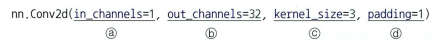
  - (a) in_channel: 입력 채널의 수
  - (b) out_channels: 출력 채널의 수
  - (c) kernel_size: 커널의 크기
  - (d) padding: 패딩 크기 => 출력 크기를 조정하기 위해 입력 데이터 주위에 0을 채움
3. BatchNorm2d: 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것

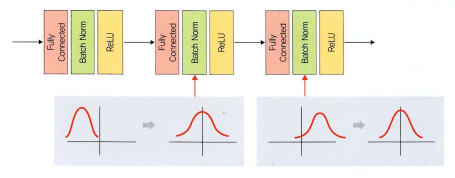
4. MaxPool2d: 이미지 크기를 축소
  - 풀링 계층: 합성곱층의 출력 데이터를 입력으로 받아 출력 데이터(activation map)의 크기를 줄이거나 특정 데이터를 강조하는 용도
  - 최대 풀링(max pooling), 평균 풀링(average pooling), 최소 풀링(min pooling)
  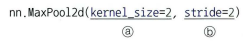
  - (a) kernel_size: mxn 행렬로 구성된 가중치
  - (b) stride: 입력 데이터에 커널(필터)을 적용할 때 이동할 간격, 스트라이드 값이 커지면 작아짐
5. 클래스를 분류하기 위해 이미지 형태의 데이터를 배열 형태로 변환하여 작업 => Conv2d에서 사용하는 하이퍼 파라미터 값들에 따라 출력 크기가 달라짐
  - 패딩과 스트라이드 값에 따라 출력 크기가 달라짐

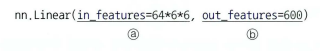
- (a) in_features: 입력 데이터의 크기

**Conv2d 계층에서 출력 크기 구하는 공식**
- 출력 크기=$(W-F+2P)/S+1$
  - $W$: 입력 데이터의 크기(input_volume_size)
  - $F$: 커널 크기(kernel_size)
  - $P$: 패딩 크기(padding_size)
  - $S$: 스트라이드(strides)

**MaxPool2d 계층에서의 출력 크기 구하는 공식**
- 출력 크기=$IF/F$
  - $IF$: 입력 필터의 크기(input_filter_size)
  - $F$: 커널 크기(kernel_size)

6. 합성곱층에서 완전연결층으로 변경되기 때문에 데이터의 형태를 1차원으로 바꾸어줌

In [22]:
# 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [23]:
# 모델 학습 및 성능 평가
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data,
                                                                  accuracy))

Iteration: 500, Loss: 0.49339503049850464, Accuracy: 88.2300033569336%
Iteration: 1000, Loss: 0.3384262025356293, Accuracy: 87.44999694824219%
Iteration: 1500, Loss: 0.3155681788921356, Accuracy: 88.83000183105469%
Iteration: 2000, Loss: 0.1972074657678604, Accuracy: 89.55000305175781%
Iteration: 2500, Loss: 0.12316051125526428, Accuracy: 90.29000091552734%
Iteration: 3000, Loss: 0.17835929989814758, Accuracy: 89.63999938964844%


- 심층 신경망과 비교하여 정확도가 약간 높음
- 이미지 데이터가 많아지면 단순 심층 신경망으로는 정확한 특성 추출 및 분류가 불가능하므로 합성곱 신경망을 생성할 수 있도록 학습해야 함